In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

/nfs4/vinit/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = datasets.ImageFolder("/home/SharedData/Vinit/ZERO_SHOT_DATASET_SHREC13/train/img",
                                 transform=transforms.ToTensor())

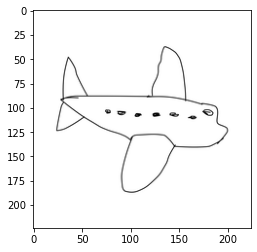

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(dataset[0][0], (1, 2, 0)))

In [4]:
from src.datamodules.components.SHREC13_shapes import SHREC13_Shapes, collate_fn

In [5]:
dataset = SHREC13_Shapes("/home/SharedData/Vinit/ZERO_SHOT_DATASET_SHREC13/" ,
                         split="train", 
                         nb_points=2048, load_textures=False,
                         dset_norm=2,
                        simplified_mesh=False)

In [6]:
data_loader = DataLoader(dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)

In [7]:
from src.utils.ops import regualarize_rendered_views

In [8]:
from src.models.components.mvtn import MVTN
from src.models.components.renderer import MVRenderer

In [9]:
mvtn = MVTN(8, views_config='circular',
            canonical_elevation= 30.0, 
            canonical_distance= 2.2,
            transform_distance=False, 
            input_view_noise=0.0, 
            shape_extractor='PointNet',
            screatch_feature_extractor=True)


mvrenderer = MVRenderer(nb_views=8, image_size=224,
                        pc_rendering=False, 
                        object_color='blue', 
                        background_color='white',
                        faces_per_pixel=2, points_radius=0.006,  points_per_pixel=1, 
                        light_direction="random", 
                        cull_backfaces=False)

In [15]:
from turtle import shape
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for labels, meshes, points in data_loader:
    c_batch_size = len(meshes)
    azim, elev, dist = mvtn(points, c_batch_size=c_batch_size)
    rendered_images, _ = mvrenderer(meshes, points, azim=azim, elev=elev, dist=dist)
    rendered_images = regualarize_rendered_views(rendered_images, 0.0, False, 0.3)

    # Plot images of all the shapes using torchvision.utils.make_grid
    for i in range(c_batch_size):
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(torchvision.utils.make_grid(rendered_images[i], nrow=4, padding=2, normalize=True), (1, 2, 0)))
        plt.show()

    print(labels)
    break

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 720x720 with 0 Axes>

In [28]:
# Find mean and std of the dataset
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for _, meshes, points in loader:
        c_batch_size = len(meshes)
        azim, elev, dist = mvtn(points, c_batch_size=c_batch_size)
        rendered_images, _ = mvrenderer(meshes, points, azim=azim, elev=elev, dist=dist)
        rendered_images = regualarize_rendered_views(rendered_images, 0.0, False, 0.3)
        
        data = rendered_images
        channels_sum += torch.mean(data, dim=[0,1,3,4])
        channels_squared_sum += torch.mean(data**2, dim=[0,1,3,4])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

In [29]:
get_mean_std(data_loader)

(tensor([0.8808, 0.8808, 0.9496], device='cuda:0'),
 tensor([0.3239, 0.3239, 0.1411], device='cuda:0'))

: 

In [11]:
rendered_images.shape

torch.Size([12, 8, 3, 224, 224])

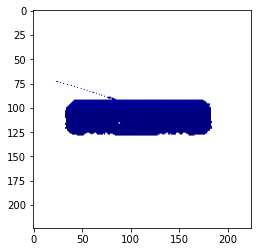

In [23]:
# Plot the images
import matplotlib.pyplot as plt

plt.imshow(rendered_images[5][4].cpu().permute(1, 2, 0))